# Stress Testing

**This code currently is still under development, so for now the results are not the conclusions.**

## Abstract

Financial markets are inherently volatile, and traditional risk models often fail to anticipate extreme events due to their reliance on historical data and oversimplified assumptions. This project introduces a novel approach to portfolio stress testing using deep generative models, specifically, a Conditional Variational Autoencoder (cVAE) and a Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP). By conditioning on macroeconomic indicators such as inflation, interest rates, volatility, and exchange rates, the models generate realistic synthetic scenarios that capture the complex, non-linear relationships between assets during periods of market stress. Applied to Warren Buffett’s Q4 2019 portfolio, the framework evaluates risk through metrics, including Value at Risk (VaR), Expected Shortfall (ES), Earth Mover’s Distance (EMD), Jensen-Shannon Divergence (JSD), and the Kolmogorov-Smirnov test. Furthermore, latent space clustering helps classify distinct stress regimes, potentially highlighting black swan events. The modular design, with dedicated components for data acquisition, preprocessing, model training, evaluation, and visualization, provides a flexible and robust foundation for both academic research and practical risk management applications.

## Variables

In [ ]:
SEED_RANDOM = 101

EPOCHS_WGAN = 1000
EPOCHS_CVAE = 500
LATENT_DIM = 8
NOISE_DIM = 10
WGANGP_PATIENCE = 400

NUM_SCENARIOS = 10000

LOAD_MODEL = False
LOGGING_ENABLED = False
USE_GPU = True

FOLDER_MODELS = "models"

START_DATE = "2004-01-01"
START_BACKTEST = "2020-02-20"
END_BACKTEST = "2020-05-01"
END_DATE = "2021-01-01"

## Imports

In [2]:
import random
import logging
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

2025-03-12 14:52:26.569339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 14:52:28.084490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 14:52:34.453441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from custom_libraries.start_gpu import gpu_available
from custom_libraries.download_data import (
    download_market_data,
    download_fred_data,
    download_other_data,
)
from custom_libraries.preprocess_data import (
    preprocess_market_data,
    preprocess_macro_data,
    process_input_features,
)
from custom_libraries.utils_plot import (
    plot_missing_values,
    plot_correlation_matrix,
    plot_stock_returns,
    plot_macro_trend,
    plot_gan_losses,
    plot_historical_vs_synthetic_var_period,
    plot_mean_grad_features,
    plot_historical_vs_synthetic_var_period_per_tickers,
)
from custom_libraries.utils import (
    save_models,
    load_models,
)
from custom_libraries.stress_backtesting import (
    rolling_backtest,
    detailed_evaluation_forecast,
    backtest_tickers_ret_syn,
)
from custom_libraries.utils_plot import (
    plot_bar_diff,
    plot_scatter_actual_vs_synthetic_oblique,
    plot_latent_space_clustering,
    plot_distribution_synthetic_portfolio,
)

In [4]:
if LOGGING_ENABLED:
    logging.basicConfig(filename="debug.log", level=logging.INFO)
else:
    logging.basicConfig(level=logging.CRITICAL)

In [5]:
gpu_available(USE_GPU)

Number of GPUs Available: 1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory limited to 8GB (8192MB)


## Data

### Parameters

In [5]:
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

start_date = START_DATE
backtest_start = START_BACKTEST
backtest_end = END_BACKTEST
end_date = END_DATE

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [6]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

### Download Market Data

In [7]:
market_data = download_market_data(tickers, pre_start_date, end_date)
market_data.head()

YF.download() has changed argument auto_adjust default to True


Price          Close                                                      \
Ticker          AAPL    AMZN        AXP        BAC       BIIB         BK   
Date                                                                       
2003-01-02  0.222693  0.9785  23.394024  20.762495  34.340000  15.763549   
2003-01-03  0.224197  1.0260  23.476961  20.633244  33.689999  15.869802   
2003-01-06  0.224197  1.0350  24.299927  20.929928  34.230000  16.663599   
2003-01-07  0.223445  1.0775  23.974560  20.962250  34.240002  16.588600   
2003-01-08  0.218931  1.0510  23.795940  20.877058  33.029999  15.938562   

Price                                                  ...   Volume          \
Ticker           COST       DVA         GL         GS  ...      PNC    SIRI   
Date                                                   ...                    
2003-01-02  19.460590  8.363333  13.479934  50.043846  ...   792500  225260   
2003-01-03  18.950764  8.460000  13.487139  50.568329  ...  1109100  117150   
2003-01-06  19.178850  8.483333  13.703859  52.450806  ...  1756200  162380   
2003-01-07  19.487419  8.416667  13.544935  52.235233  ...  1597900  641390   
2003-01-08  19.655123  8.376667  13.508815  50.956310  ...  1335400  553830   

Price                                                                       \
Ticker           SPY      SU     TEVA      TRV      UPS      USB      VRSN   
Date                                                                         
2003-01-02  44516300  864800  6000400   833000  2805000  5131000   6949000   
2003-01-03  32222600  757200  4711600   961100  1935500  3398700   3147300   
2003-01-06  40984500  718000  7149600  1200300  3052500  6704900   5064200   
2003-01-07  38640400  631600  6454800  1441100  2370400  5067900  10772800   
2003-01-08  38702200  751200  3277400  1385300  1680900  3579900  10515000   

Price                
Ticker          WFC  
Date                 
2003-01-02  9904200  
2003-01-03  7808000  
2003-01-06  8097400  
2003-01-07  6556200  
2003-01-08  8071000  

[5 rows x 150 columns]

In [8]:
returns_all, returns_train, returns_test, returns_train_scaled, returns_scaler = (
    preprocess_market_data(market_data, start_date, backtest_start, backtest_end)
)
returns_train.head()

Ticker          AAPL      AMZN       AXP       BAC      BIIB        BK  \
Date                                                                     
2004-01-02 -0.004220 -0.013777 -0.010002 -0.016801  0.006518 -0.009404   
2004-01-05  0.040973  0.026055  0.008757  0.002904  0.004322  0.040908   
2004-01-06 -0.003616 -0.004516  0.001659 -0.001640  0.039376  0.015387   
2004-01-07  0.022384 -0.021539  0.002897 -0.002275  0.055444 -0.035185   
2004-01-08  0.033518 -0.032507 -0.002897  0.000506  0.011214 -0.001194   

Ticker          COST       DVA        GL        GS  ...       PNC      SIRI  \
Date                                                ...                       
2004-01-02 -0.023402  0.012992  0.000439 -0.016338  ... -0.004395  0.189679   
2004-01-05 -0.004691  0.011075  0.007015  0.000514  ... -0.013487 -0.087488   
2004-01-06  0.011277 -0.012341 -0.002625 -0.005986  ...  0.008335 -0.040822   
2004-01-07  0.014123 -0.004063 -0.001096  0.020797  ... -0.002955 -0.058209   
2004-01-08  0.004842 -0.006894  0.000000  0.001216  ... -0.003150  0.058209   

Ticker           SPY        SU      TEVA       TRV       UPS       USB  \
Date                                                                     
2004-01-02 -0.000450  0.016228  0.020248 -0.001262 -0.012146 -0.007315   
2004-01-05  0.010820  0.008990  0.027105  0.002522  0.003794 -0.009998   
2004-01-06  0.000978  0.018887 -0.016277 -0.007585 -0.006106 -0.015012   
2004-01-07  0.003370 -0.017720 -0.003939  0.000000 -0.003271 -0.000704   
2004-01-08  0.003977 -0.027582 -0.002233  0.006325 -0.008226 -0.006710   

Ticker          VRSN       WFC  
Date                            
2004-01-02  0.002451 -0.012302  
2004-01-05  0.045462  0.004803  
2004-01-06  0.045722 -0.003256  
2004-01-07 -0.017470 -0.010179  
2004-01-08  0.043932 -0.000347  

[5 rows x 30 columns]

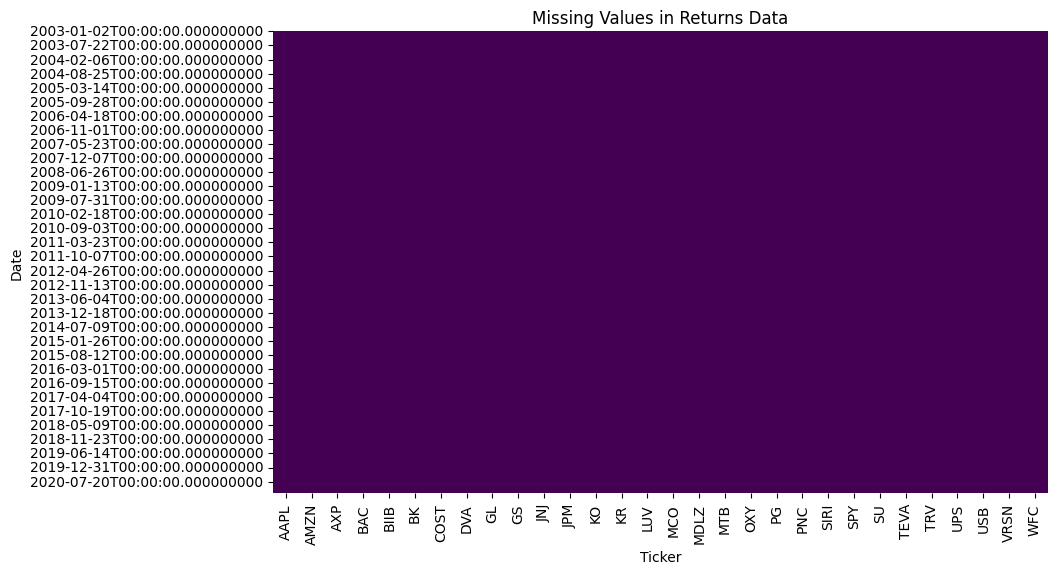

In [9]:
plot_missing_values(returns_all, "Missing Values in Returns Data")

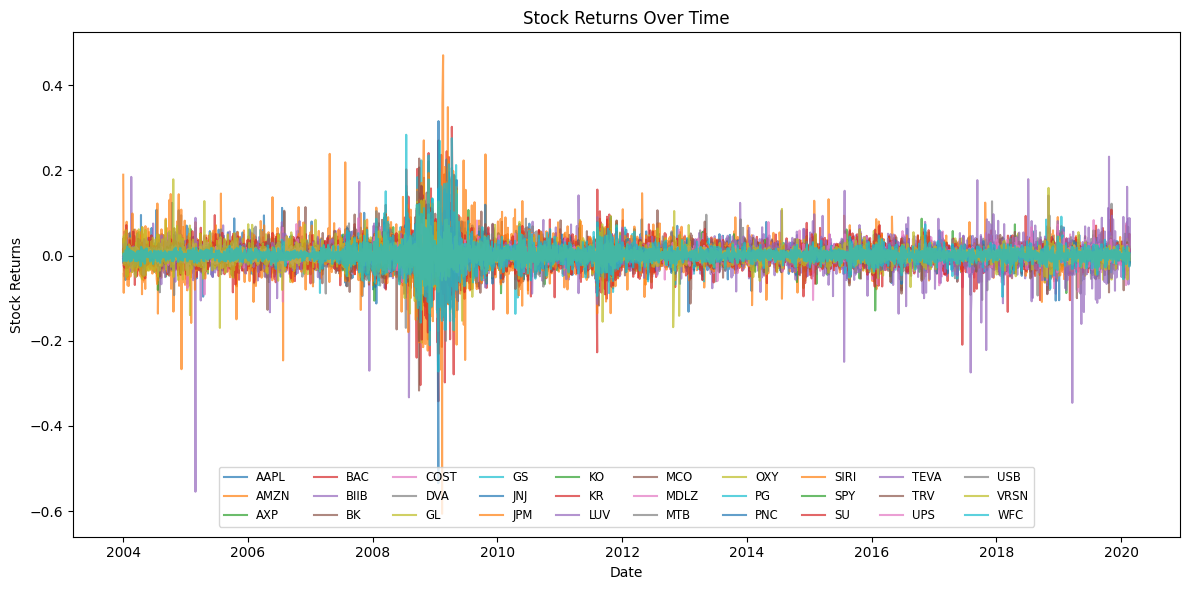

In [10]:
plot_stock_returns(returns_train)

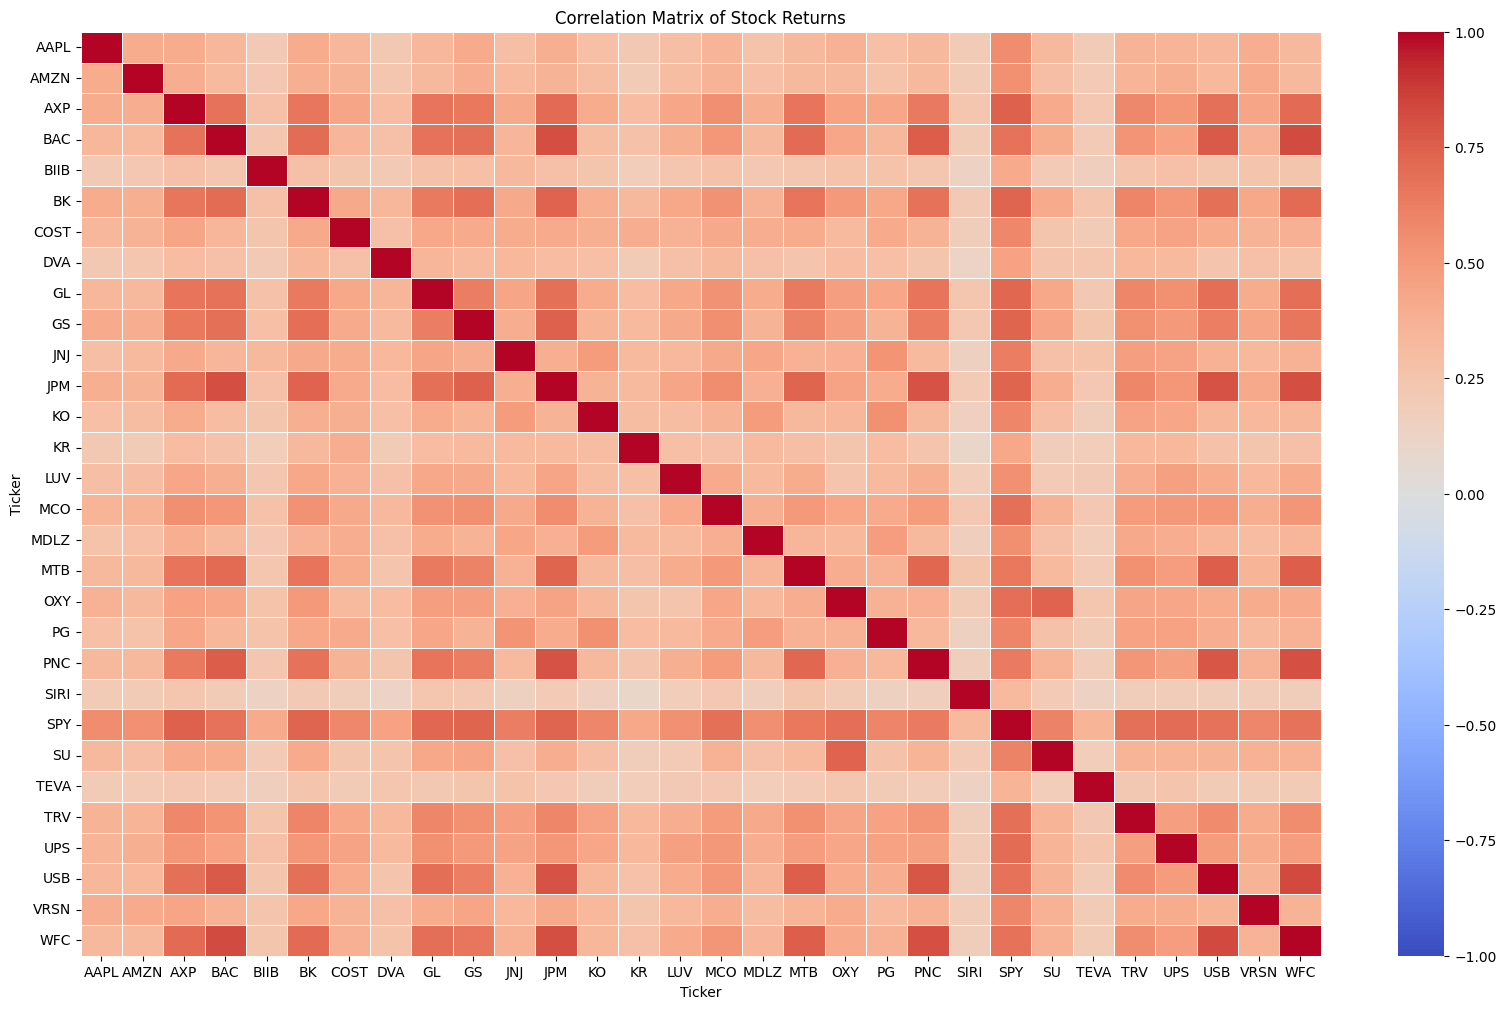

In [11]:
plot_correlation_matrix(
    returns_train, "Correlation Matrix of Stock Returns", figsize=(20, 12), annot=False
)

### Download and Prepare Macroeconomic Indicators

/home/amogus/github/pst/custom_libraries/preprocess_data.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df_shifted = macro_df_shifted.fillna(method="ffill")


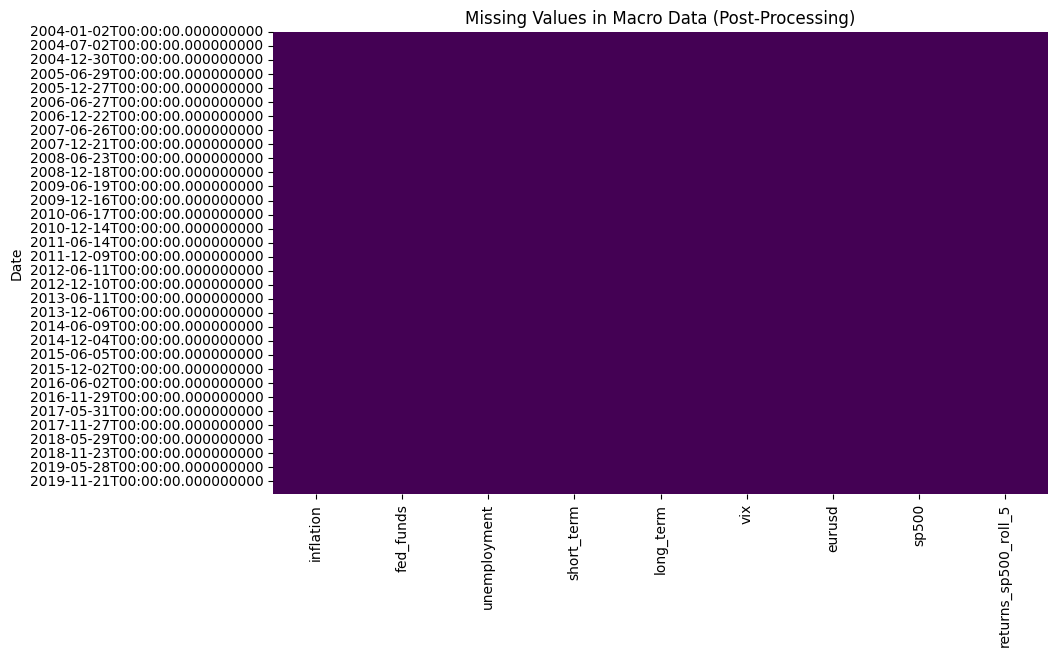

In [12]:
# Load FRED API Key
with open("key_fred.txt", "r") as file:
    fred_api_key = file.read().strip()

# Download FRED series
fred_data = download_fred_data(fred_api_key, pre_start_date, end_date)
vix_data, fx_data, sp500_data = download_other_data(pre_start_date, end_date)

macro_df = preprocess_macro_data(
    fred_data, vix_data, fx_data, sp500_data, start_date, backtest_end, returns_all.index
)

In [13]:
macro_df.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  
Date                                                             
2004-01-02  18.309999  1.259002  0.002053             -0.003099  
2004-01-05  18.219999  1.258194 -0.003099              0.000000  
2004-01-06  17.490000  1.268698  0.012319             -0.000321  
2004-01-07  16.730000  1.272103  0.001291             -0.001612  
2004-01-08  15.500000  1.264095  0.002364             -0.004547

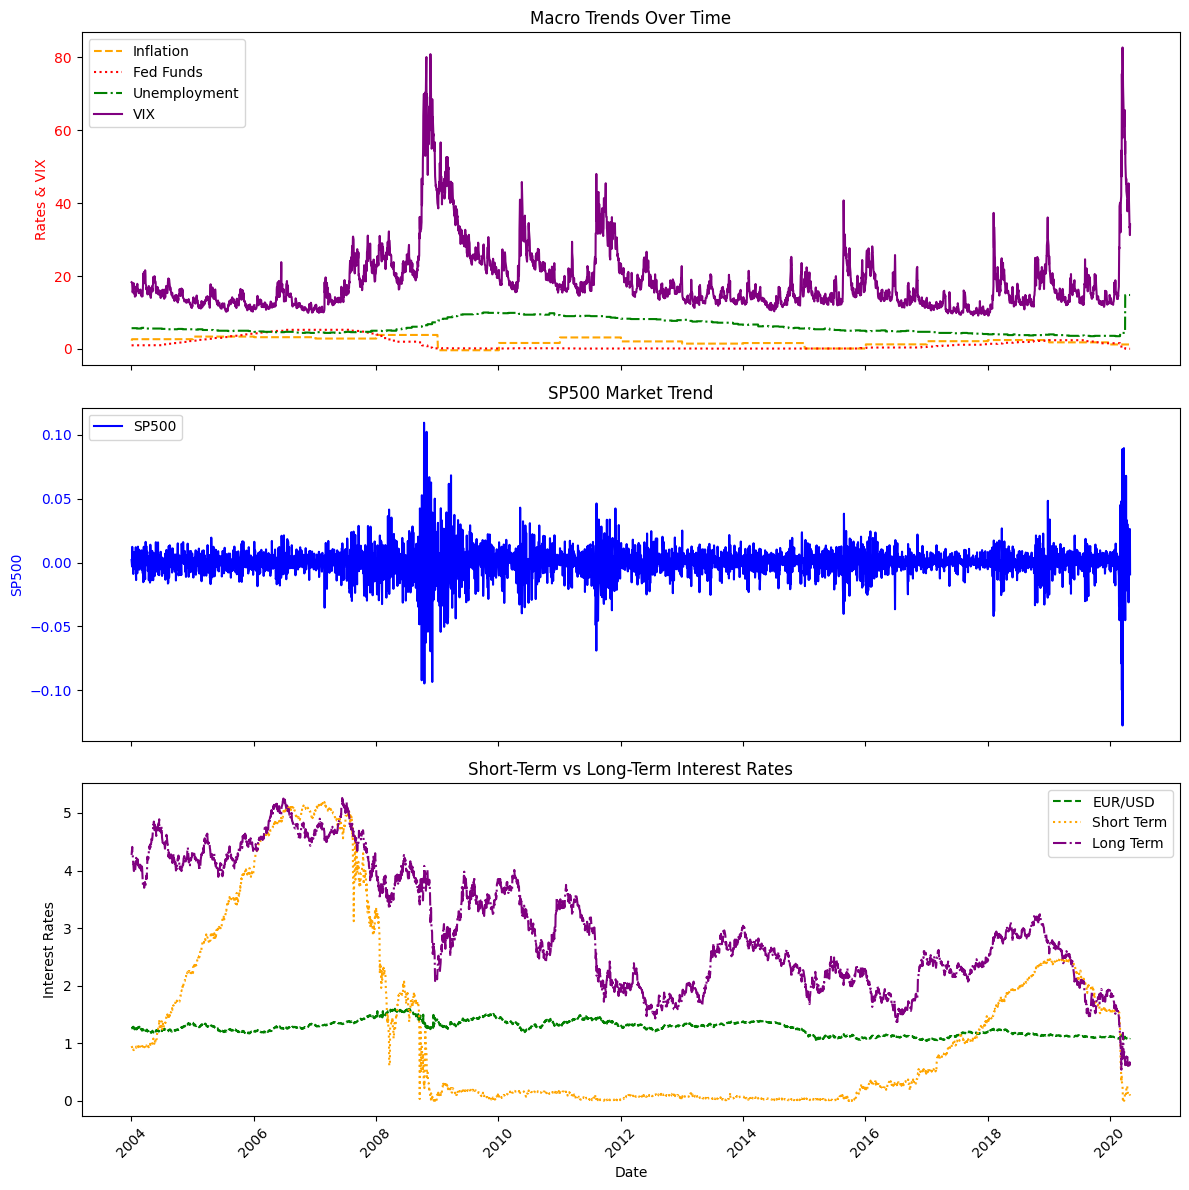

In [14]:
plot_macro_trend(macro_df)

In [15]:
input_features = process_input_features(
    macro_df,
    returns_all,
    market_data,
    start_date,
    end_date,
    portfolio_weights,
)

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  \
Date                                                              
2004-01-02  18.309999  1.259002  0.002053             -0.003099   
2004-01-05  18.219999  1.258194 -0.003099              0.000000   
2004-01-06  17.490000  1.268698  0.012319             -0.000321   
2004-01-07  16.730000  1.272103  0.001291             -0.001612   
2004-01-08  15.500000  1.264095  0.002364             -0.004547   

            portfolio_volatility  portfolio_volume  
Date                                                
2004-01-02              0.011617      7.338336e+07  
2004-01-05              0.012135      1.742616e+08  
2004-01-06              0.012069      1.974032e+08  
2004-01-07              0.012103      2.344443e+08  
2004-01-08              0.010964      1.942956e+08

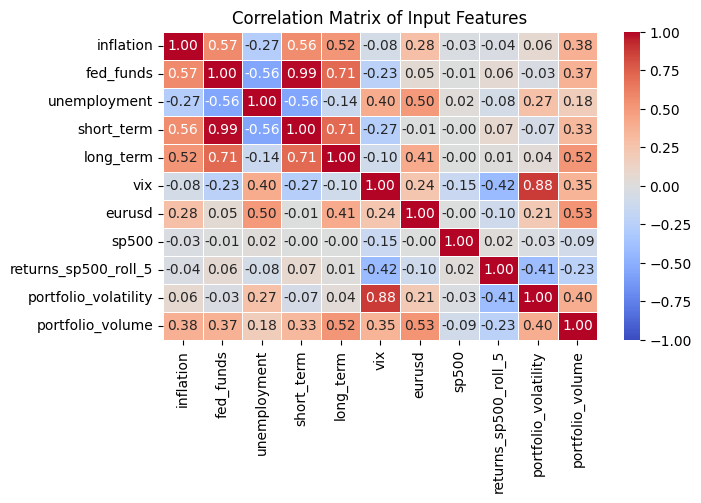

In [16]:
plot_correlation_matrix(input_features, "Correlation Matrix of Input Features")

In [17]:
print(f"#Nan in Input Features : {input_features.isna().sum().sum()}")

#Nan in Input Features : 0


In [18]:
input_train = input_features.loc[start_date:backtest_start]
input_test = input_features.loc[backtest_start:backtest_end]

# Scale input_features indicators
input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [19]:
from custom_libraries.custome_layer import (
    KLDivergenceLayer,
    SamplingLayer,
    ReconstructionLossLayer,
)

# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer,
}

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [20]:
from custom_libraries.custom_vae import (
    build_conditional_vae,
)

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [21]:
from custom_libraries.custom_wgangp import (
    build_conditional_generator,
    build_conditional_critic,
    train_conditional_wgan_gp,
)

## Training and Stress Testing

In [22]:
n_samples = min(returns_train_scaled.shape[0], input_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
macro_train_scaled = input_train_scaled[:n_samples]

### VAE

In [23]:
return_dim = returns_scaled.shape[1]
input_dim = input_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Returns dim: {return_dim}")
print(f"Input dim: {input_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Returns dim: 30
Input dim: 11
Latent dim: 8
Noise dim: 10


In [25]:
if not LOAD_MODEL:
    print("Training Conditional VAE...")
    encoder, decoder, cvae, early_stop = build_conditional_vae(
        return_dim, input_dim, intermediate_dim=256, latent_dim=latent_dim
    )

    cvae.fit(
        [returns_scaled, input_train_scaled],
        epochs=EPOCHS_CVAE,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1741797470.260649   26916 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/500


2025-03-12 12:37:51.539467: I external/local_xla/xla/service/service.cc:152] XLA service 0x7cfabc00dd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-12 12:37:51.539479: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-12 12:37:51.568431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741797471.708842   27101 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-12 12:37:53.777554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 40 bytes spill stores, 40 bytes spill loads

2025-03-12 12:37:54.311365: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spille

 72/115 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 2.2425

I0000 00:00:1741797475.659029   27101 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-12 12:37:56.806208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 4 bytes spill stores, 4 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.1625 

2025-03-12 12:37:59.840640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 12:37:59.878904: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 12:38:01.449117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-03-12 12:38:01.548314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 8 bytes spill stores, 8 bytes spill loads

2025-03-12 12:38:01.595414: I external/local_xla/xla/str

115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 2.1608 - val_loss: 1.5125
Epoch 2/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 1.5426 - val_loss: 1.3274
Epoch 3/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 1.4279 - val_loss: 1.2770
Epoch 4/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 1.3696 - val_loss: 1.2495
Epoch 5/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 1.3314 - val_loss: 1.2590
Epoch 6/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.3196 - val_loss: 1.2476
Epoch 7/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.2960 - val_loss: 1.2636
Epoch 8/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.2855 - val_loss: 1.2459
Epoch 9/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2865 - val_loss: 1.2293
Epoch 10/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.2555 - val_loss: 1.2748
Epoch 11/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 1.2394 - val_loss: 1.2488
Epoch 12/500
115/115 ━━━━━━━━━━━━

2025-03-12 12:38:05.733779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


### WGAN-GP

In [26]:
if not LOAD_MODEL:
    print("Training Conditional WGAN-GP...")
    generator = build_conditional_generator(noise_dim, input_dim, latent_dim)
    critic = build_conditional_critic(latent_dim, input_dim)
    generator, gen_losses, critic_losses, val_losses = train_conditional_wgan_gp(
        generator,
        critic,
        z_mean_train,
        input_train_scaled,
        input_test,
        noise_dim,
        epochs=EPOCHS_WGAN,
        important_index="returns_sp500_roll_5",
        patience=WGANGP_PATIENCE,
    )

Training Conditional WGAN-GP...


/home/amogus/github/tf/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-03-12 12:38:20.931674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 9.2777, Gen Loss = -0.3262, Val Loss = -0.9303


2025-03-12 12:38:32.916608: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 12:38:58.604453: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 12:39:47.524031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10: Critic Loss = -0.7181, Gen Loss = 0.2585, Val Loss = 1.8168


2025-03-12 12:41:28.809504: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Critic Loss = -0.5396, Gen Loss = -0.7641, Val Loss = 0.4238
Epoch 30: Critic Loss = -0.4027, Gen Loss = -0.7759, Val Loss = 0.0109


2025-03-12 12:44:42.401601: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40: Critic Loss = -0.3190, Gen Loss = -0.5704, Val Loss = -0.3487
Epoch 50: Critic Loss = -0.3252, Gen Loss = -0.3361, Val Loss = -0.3253
Epoch 60: Critic Loss = -0.2774, Gen Loss = -0.2882, Val Loss = -0.3713


2025-03-12 12:51:47.806238: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70: Critic Loss = -0.1954, Gen Loss = -0.4650, Val Loss = -0.5610
Epoch 80: Critic Loss = -0.1356, Gen Loss = -0.8001, Val Loss = -0.8409
Epoch 90: Critic Loss = -0.1114, Gen Loss = -0.6896, Val Loss = -0.6882
Epoch 100: Critic Loss = -0.1225, Gen Loss = -0.0773, Val Loss = -0.2544
Epoch 110: Critic Loss = -0.1061, Gen Loss = -0.1164, Val Loss = -0.3304
Epoch 120: Critic Loss = -0.0747, Gen Loss = -0.2251, Val Loss = -0.4756


2025-03-12 13:05:34.039221: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130: Critic Loss = -0.0677, Gen Loss = -0.3299, Val Loss = -0.5715
Epoch 140: Critic Loss = -0.0563, Gen Loss = -0.4114, Val Loss = -0.5793
Epoch 150: Critic Loss = -0.0493, Gen Loss = -0.4980, Val Loss = -0.6104
Epoch 160: Critic Loss = -0.0473, Gen Loss = -0.4893, Val Loss = -0.6085
Epoch 170: Critic Loss = -0.0454, Gen Loss = -0.5154, Val Loss = -0.6110
Epoch 180: Critic Loss = -0.0390, Gen Loss = -0.5099, Val Loss = -0.6218
Epoch 190: Critic Loss = -0.0317, Gen Loss = -0.4952, Val Loss = -0.6183
Epoch 200: Critic Loss = -0.0252, Gen Loss = -0.4831, Val Loss = -0.6032
Epoch 210: Critic Loss = -0.0190, Gen Loss = -0.4701, Val Loss = -0.6032
Epoch 220: Critic Loss = -0.0143, Gen Loss = -0.4658, Val Loss = -0.5754
Epoch 230: Critic Loss = -0.0111, Gen Loss = -0.4749, Val Loss = -0.5684
Epoch 240: Critic Loss = -0.0085, Gen Loss = -0.4751, Val Loss = -0.5667
Epoch 250: Critic Loss = -0.0035, Gen Loss = -0.4771, Val Loss = -0.5600


2025-03-12 13:32:14.053021: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260: Critic Loss = -0.0020, Gen Loss = -0.4996, Val Loss = -0.5626
Epoch 270: Critic Loss = 0.0012, Gen Loss = -0.5393, Val Loss = -0.5860
Epoch 280: Critic Loss = 0.0025, Gen Loss = -0.5385, Val Loss = -0.5799
Epoch 290: Critic Loss = 0.0057, Gen Loss = -0.5588, Val Loss = -0.5762
Epoch 300: Critic Loss = 0.0056, Gen Loss = -0.6045, Val Loss = -0.6078
Epoch 310: Critic Loss = 0.0106, Gen Loss = -0.6283, Val Loss = -0.6486
Epoch 320: Critic Loss = 0.0084, Gen Loss = -0.6180, Val Loss = -0.6396
Epoch 330: Critic Loss = 0.0091, Gen Loss = -0.6203, Val Loss = -0.6357
Epoch 340: Critic Loss = 0.0090, Gen Loss = -0.6238, Val Loss = -0.6543
Epoch 350: Critic Loss = 0.0089, Gen Loss = -0.6141, Val Loss = -0.6352
Epoch 360: Critic Loss = 0.0087, Gen Loss = -0.6249, Val Loss = -0.6268
Epoch 370: Critic Loss = 0.0090, Gen Loss = -0.6194, Val Loss = -0.6113
Epoch 380: Critic Loss = 0.0089, Gen Loss = -0.6540, Val Loss = -0.6194
Epoch 390: Critic Loss = 0.0099, Gen Loss = -0.6272, Val Loss =

#### Plot Losses

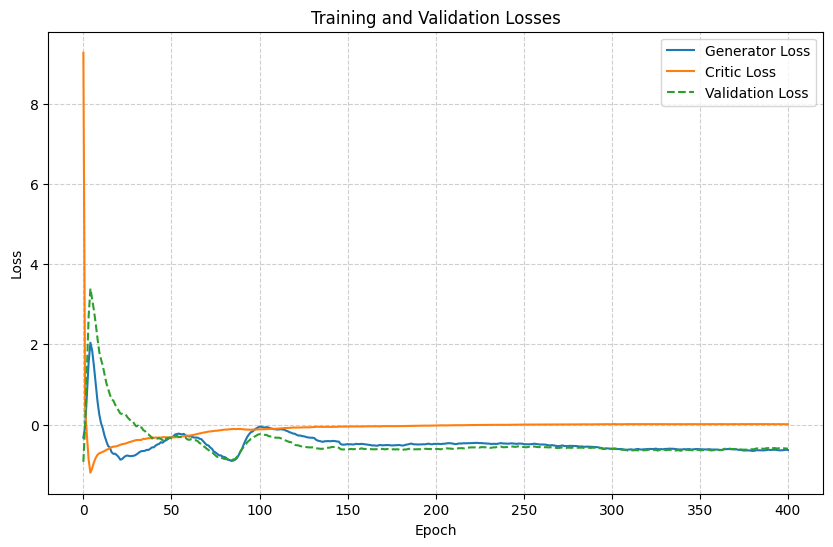

In [27]:
if not LOAD_MODEL:
    plot_gan_losses(gen_losses, critic_losses, val_losses)

### Save & Load Models

In [ ]:
if LOAD_MODEL:
    encoder, decoder, cvae, generator, critic = load_models(
        custom_objects, FOLDER_MODELS
    )
    print("Load models")
else:
    save_models(encoder, decoder, cvae, generator, critic, FOLDER_MODELS)
    print("Save models")

Save models


### Generate New Synthetic Scenarios

#### Scenario

In [26]:
input_test.describe()

inflation  fed_funds  unemployment  short_term  long_term        vix  \
count  51.000000  51.000000     51.000000   51.000000  51.000000  51.000000   
mean    1.233584   0.548824      8.541176    0.420196   0.861961  46.028824   
std     0.000000   0.528339      5.297591    0.523242   0.273511  15.901561   
min     1.233584   0.050000      3.500000    0.000000   0.540000  14.380000   
25%     1.233584   0.050000      4.400000    0.105000   0.635000  36.375000   
50%     1.233584   0.650000      4.400000    0.140000   0.760000  41.980000   
75%     1.233584   0.650000     14.800000    0.445000   1.020000  57.070002   
max     1.233584   1.580000     14.800000    1.580000   1.560000  82.690002   

          eurusd      sp500  returns_sp500_roll_5  portfolio_volatility  \
count  51.000000  51.000000             51.000000             51.000000   
mean    1.095674  -0.002863             -0.047158              0.040343   
std     0.017598   0.043055              0.049729              0.015246   
min     1.065735  -0.127652             -0.188892              0.009549   
25%     1.083072  -0.030240             -0.076627              0.029237   
50%     1.088957  -0.003823             -0.031155              0.048091   
75%     1.104979   0.024454             -0.001072              0.053501   
max     1.139796   0.089683              0.000000              0.056147   

       portfolio_volume  
count      5.100000e+01  
mean       1.105985e+08  
std        3.816572e+07  
min        4.950988e+07  
25%        8.053516e+07  
50%        1.028735e+08  
75%        1.413045e+08  
max        1.974422e+08

In [27]:
stress_values = {
#    "fed_funds": 0.01,
#    "long_term": 2.0,
#    "vix": 99.0,
#    "eurusd": 2.0,
#    "inflation": 4.0,
#    "unemployment": 20.0,
    "returns_sp500_roll_5": -0.2,
}


#### Backtesting

In [28]:
backtest_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
)

2025-03-12 14:53:19.905695: I external/local_xla/xla/service/service.cc:152] XLA service 0x7410600055d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-12 14:53:19.905707: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-12 14:53:19.909540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741805599.921058   73888 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-12 14:53:20.675116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 4 bytes spill stores, 4 bytes spill loads



259/313 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step

I0000 00:00:1741805601.031640   73888 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
313/313 ━━━━━

In [29]:
print("Rolling backtest results:")
backtest_df.head()

Rolling backtest results:


forecast_date  hist_portfolio_return  synthetic_VaR  synthetic_ES
0    2020-02-20              -0.006224      -0.087371     -0.087980
1    2020-02-21              -0.016266      -0.085485     -0.086286
2    2020-02-24              -0.042082      -0.085090     -0.086125
3    2020-02-25              -0.032877      -0.076891     -0.078227
4    2020-02-26               0.001837      -0.076455     -0.077752

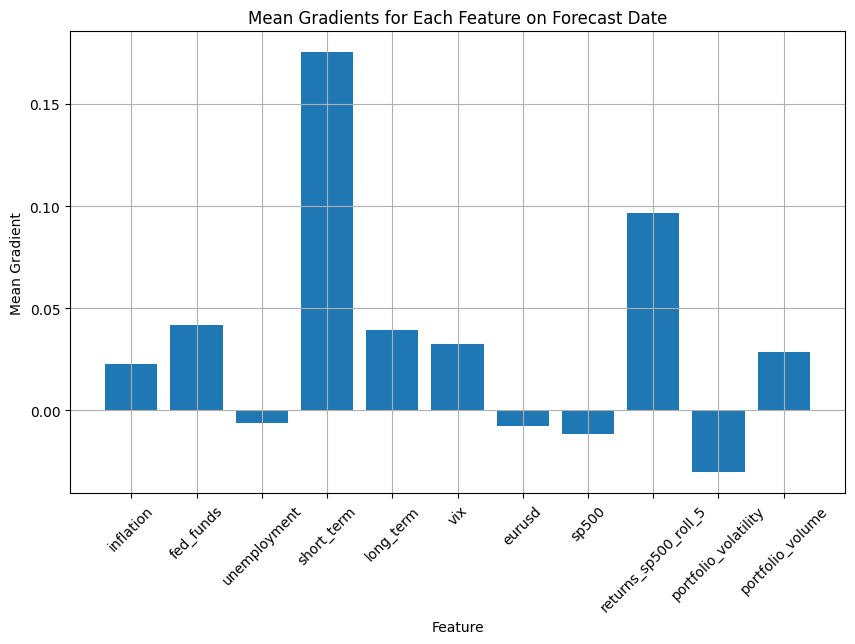

In [30]:
plot_mean_grad_features(input_test, generator)

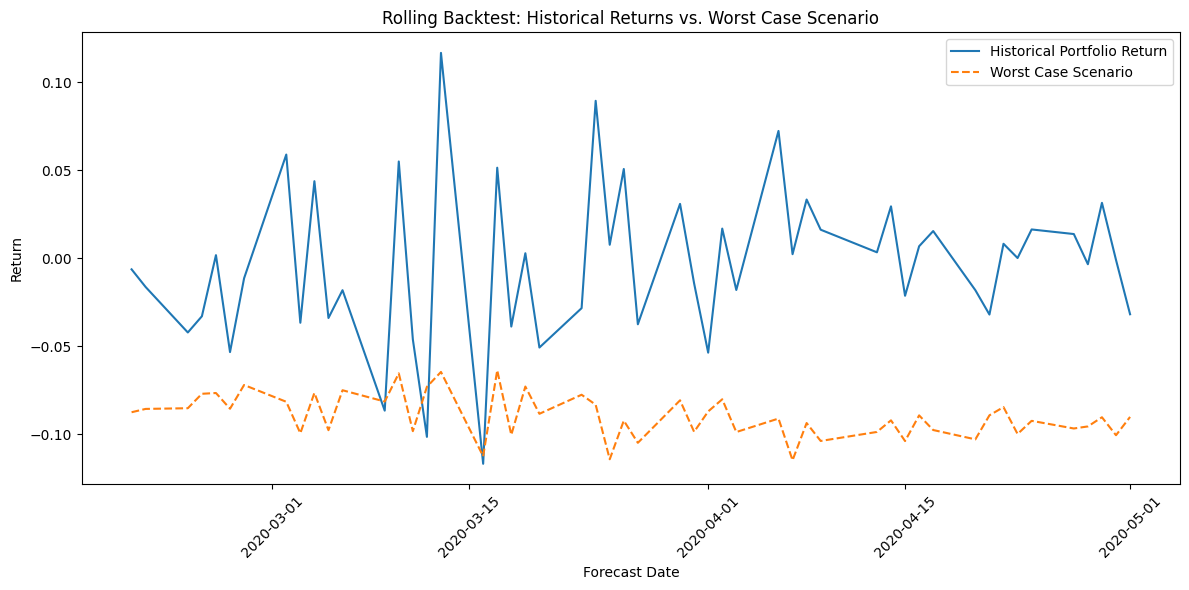

In [31]:
plot_historical_vs_synthetic_var_period(backtest_df)

In [32]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
313/313 ━━━

In [33]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001962          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014585          0.010252       -0.005304          0.002686   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.080977          -0.075181   
1        -0.006638       -0.009218  ...         -0.079284          -0.074623   
2        -0.014735       -0.032012  ...         -0.079672          -0.075548   
3        -0.022086       -0.034235  ...         -0.072897          -0.071296   
4        -0.000123       -0.022963  ...         -0.073012          -0.069884   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.055133        -0.097827          -0.079503         -0.059625   
1         -0.054816        -0.096908          -0.078261         -0.058397   
2         -0.055689        -0.097708          -0.077657         -0.058998   
3         -0.052090        -0.090423          -0.070644         -0.052787   
4         -0.051643        -0.089302          -0.069423         -0.052498   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.057987         -0.066876          -0.093778         -0.048731  
1         -0.057439         -0.065260          -0.092941         -0.048397  
2         -0.057629         -0.064911          -0.093893         -0.051111  
3         -0.053636         -0.058031          -0.086905         -0.048530  
4         -0.053226         -0.058170          -0.086124         -0.048861  

[5 rows x 91 columns]

In [34]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
313/313 ━━━

In [35]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001962          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014585          0.010252       -0.005304          0.002686   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.080989          -0.075182   
1        -0.006638       -0.009218  ...         -0.079347          -0.074655   
2        -0.014735       -0.032012  ...         -0.079770          -0.075598   
3        -0.022086       -0.034235  ...         -0.072835          -0.071265   
4        -0.000123       -0.022963  ...         -0.072926          -0.069870   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.055138        -0.097837          -0.079510         -0.059630   
1         -0.054864        -0.097016          -0.078288         -0.058438   
2         -0.055758        -0.097855          -0.077718         -0.059057   
3         -0.052042        -0.090335          -0.070593         -0.052743   
4         -0.051581        -0.089192          -0.069382         -0.052440   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.057992         -0.066882          -0.093784         -0.048738  
1         -0.057472         -0.065299          -0.093017         -0.048510  
2         -0.057685         -0.064982          -0.093989         -0.051255  
3         -0.053598         -0.057977          -0.086851         -0.048428  
4         -0.053185         -0.058117          -0.086041         -0.048751  

[5 rows x 91 columns]

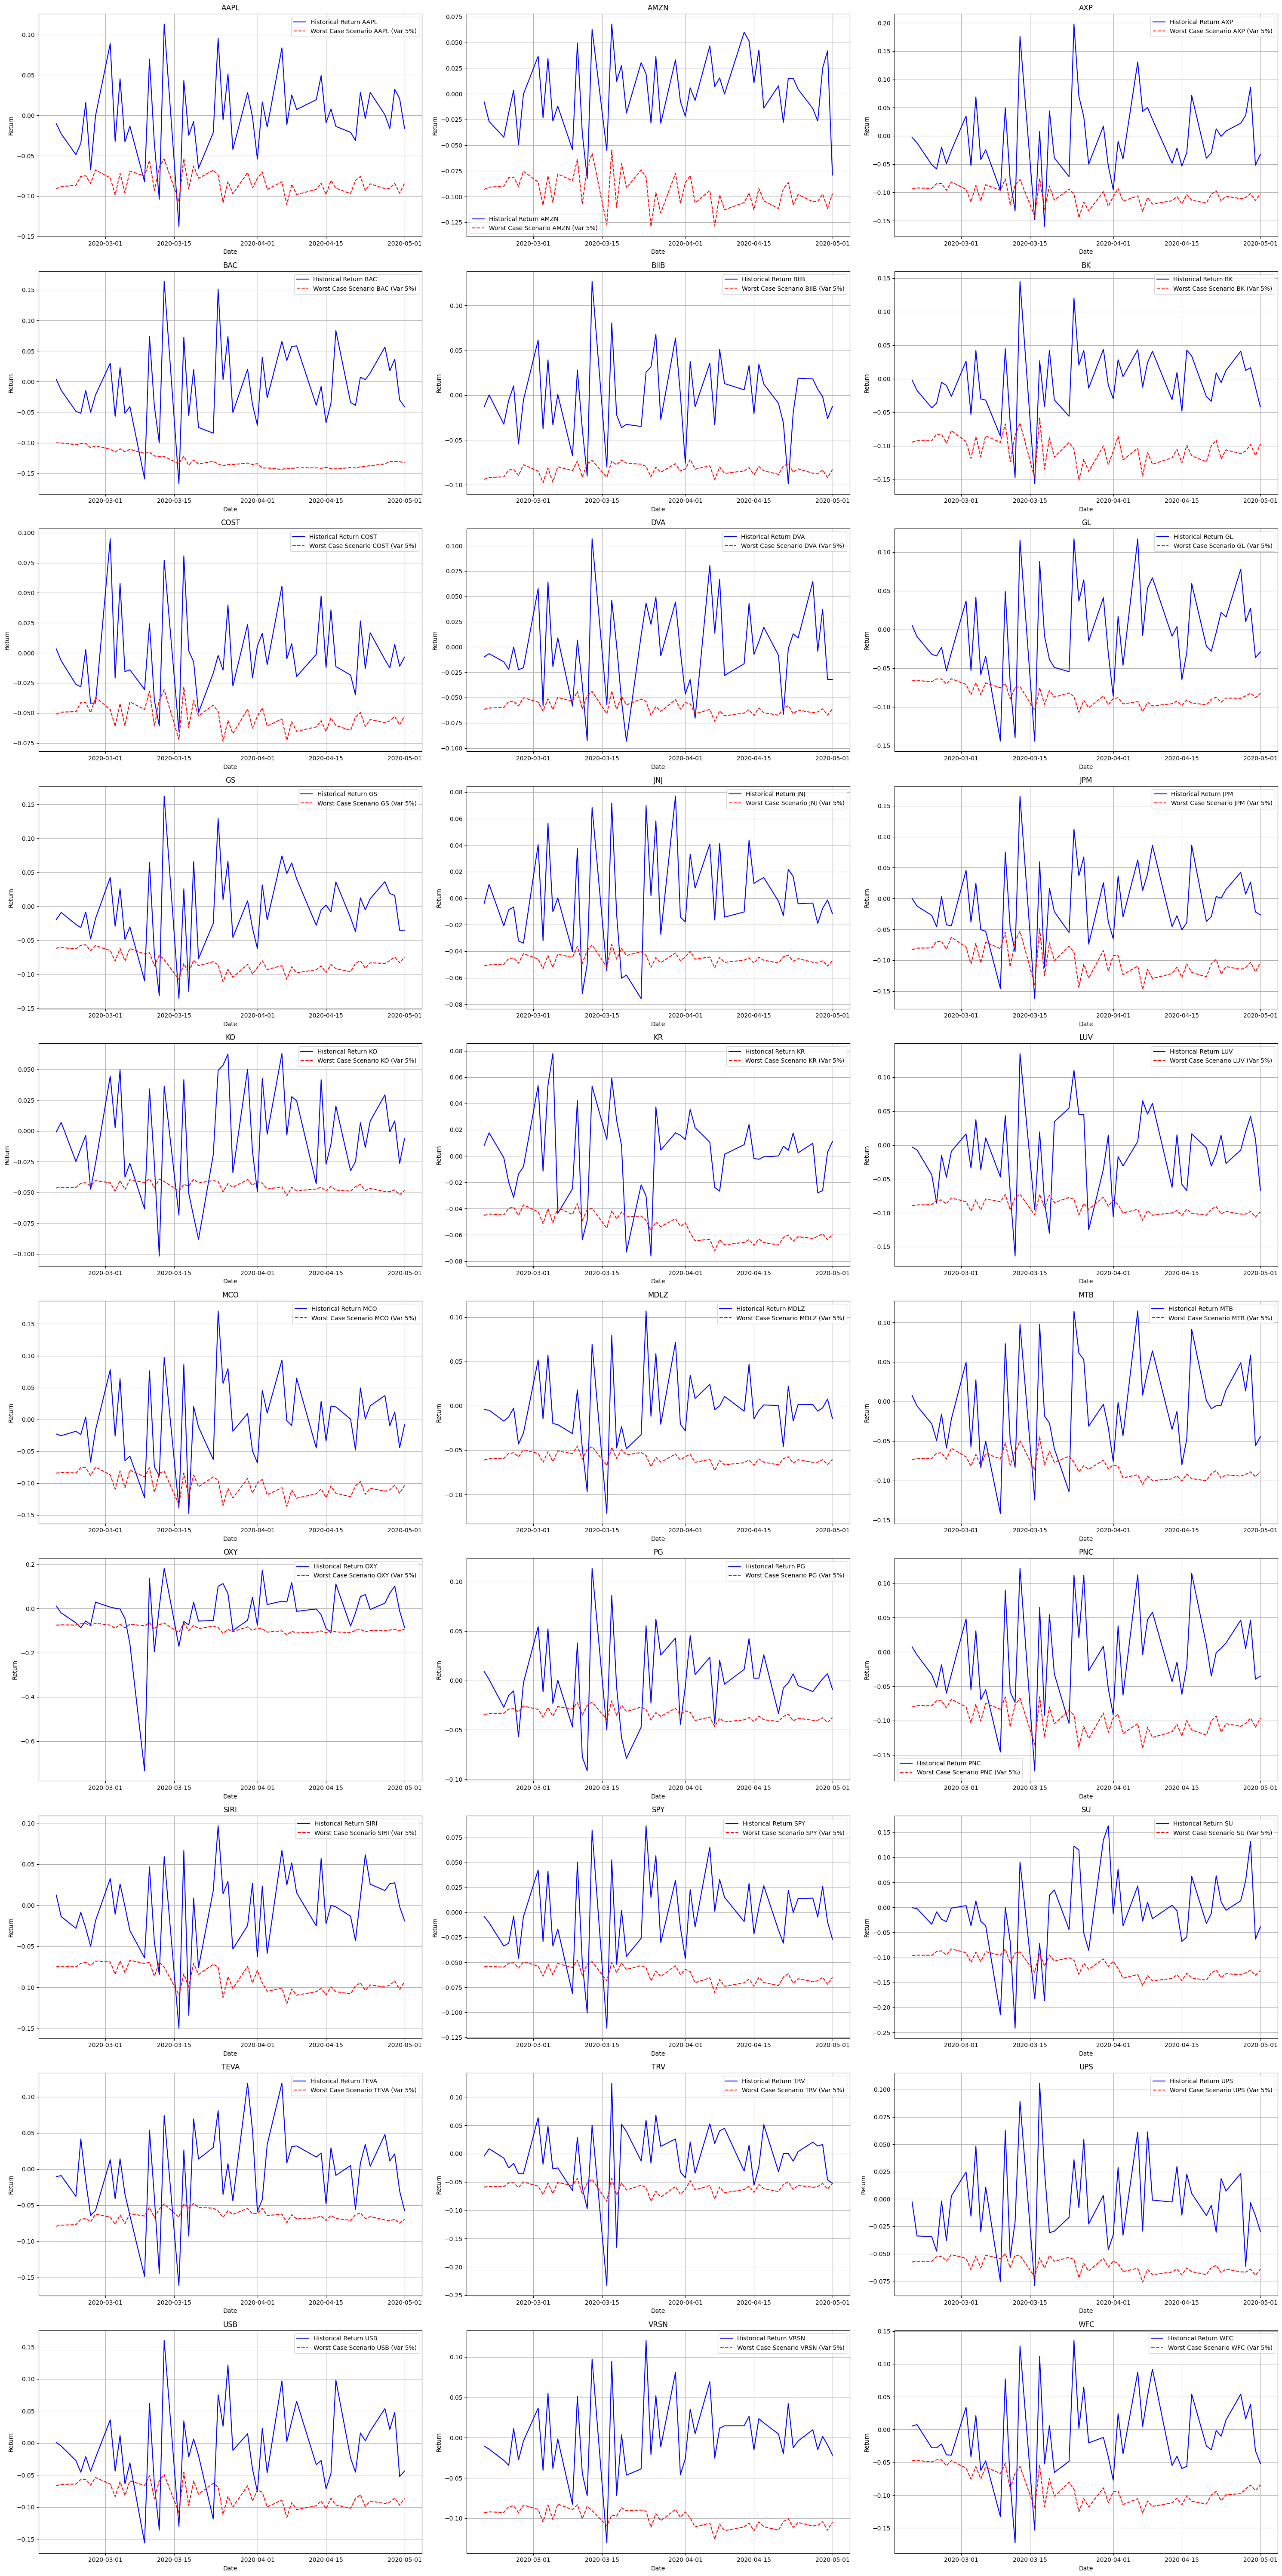

In [36]:
plot_historical_vs_synthetic_var_period_per_tickers(backtest_tickers_df, returns_test)

In [37]:
tickers_list = returns_test.columns.tolist()

hist_returns, synthetic_vars = backtest_tickers_ret_syn(
    tickers_list, backtest_tickers_df
)

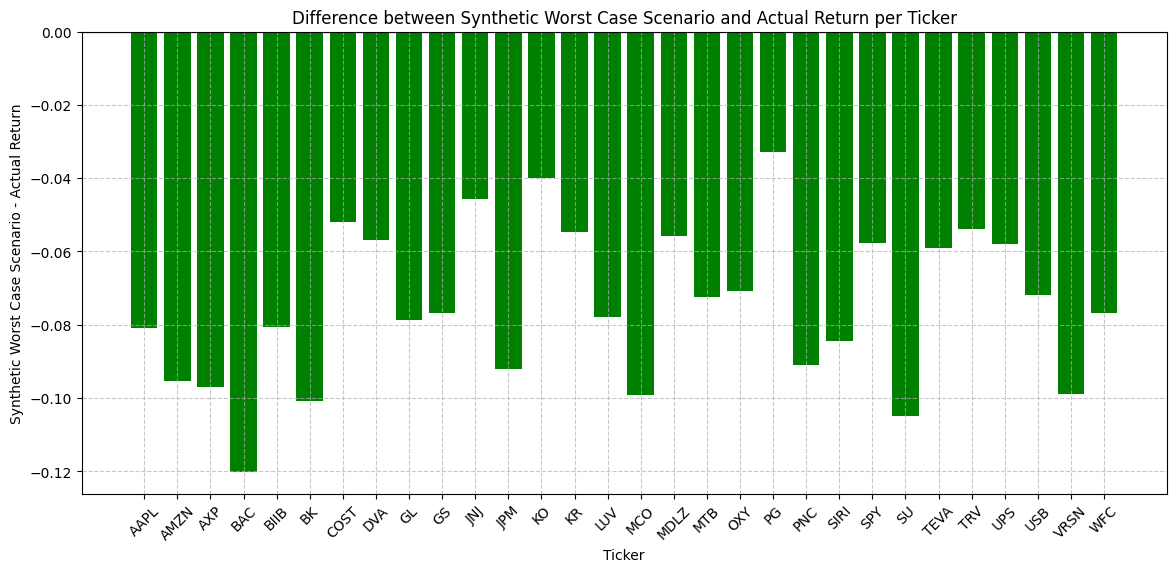

In [38]:
plot_bar_diff(hist_returns, synthetic_vars, tickers_list)

/home/amogus/github/pst/custom_libraries/utils_plot.py:361: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


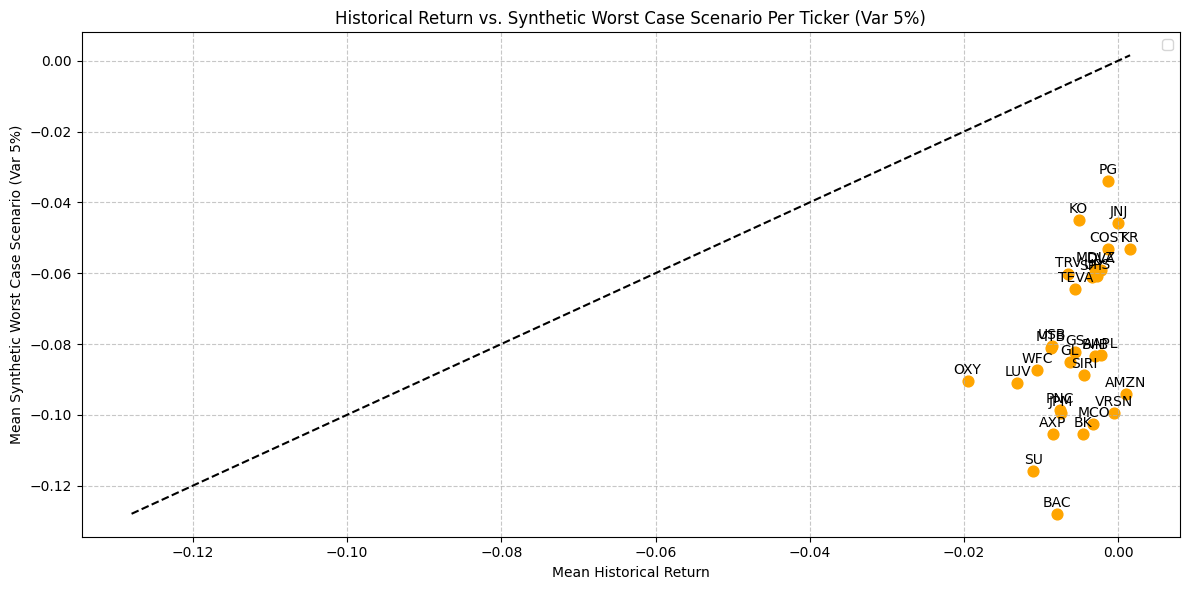

In [39]:
plot_scatter_actual_vs_synthetic_oblique(hist_returns, synthetic_vars, tickers_list)

2025-03-12 14:53:57.365615: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:45 837ms/step

2025-03-12 14:53:58.276105: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step  


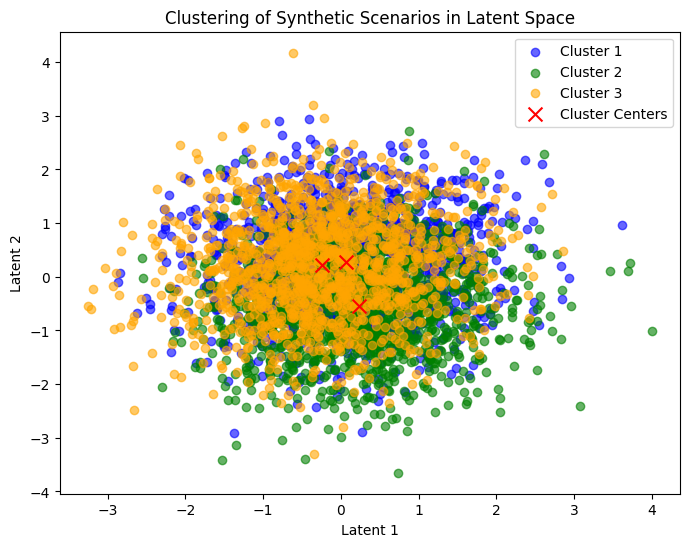

In [40]:
plot_latent_space_clustering(encoder, returns_train_scaled, SEED_RANDOM)

In [41]:
synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d = (
    detailed_evaluation_forecast(
        returns_test,
        input_test_scaled,
        generator,
        decoder,
        returns_scaler,
        NUM_SCENARIOS,
        NOISE_DIM,
        portfolio_weights,
        index_date=0,
    )
)

Forecast date: 2020-02-20 00:00:00
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
Detailed evaluation for forecast date: 2020-02-20 00:00:00
Synthetic Portfolio Returns - Summary:
count    10000.000000
mean        -0.039331
std          0.000396
min         -0.041374
25%         -0.039605
50%         -0.039406
75%         -0.039029
max         -0.038191
dtype: float64
Synthetic VaR (5th percentile): -0.0399
Synthetic ES: -0.0401


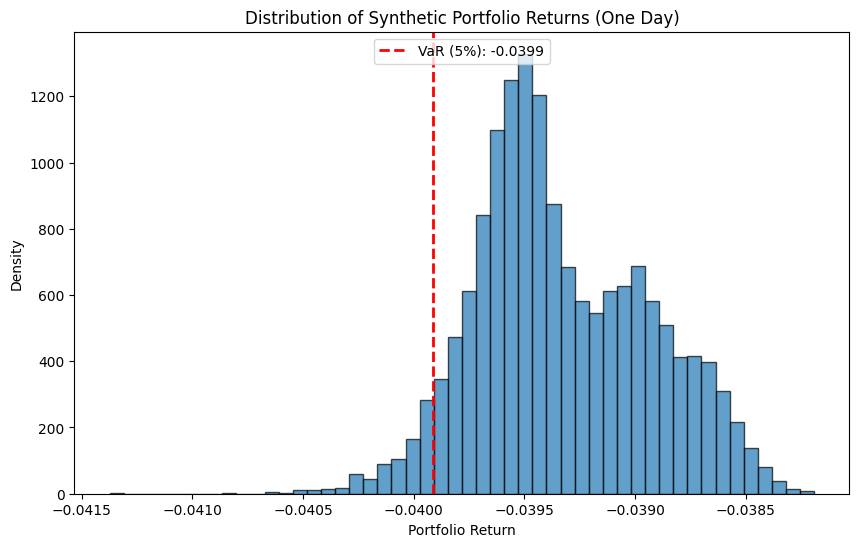

In [42]:
plot_distribution_synthetic_portfolio(synthetic_portfolio_returns_d, var_synth_d)

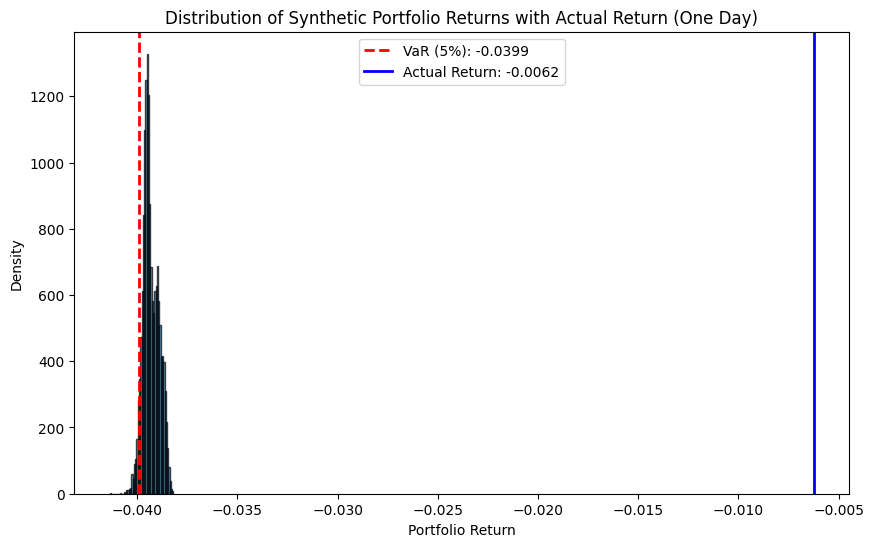

In [43]:
plot_distribution_synthetic_portfolio(
    synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d
)